In [40]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


In [41]:
import pandas as pd

df = pd.read_csv("datasets/AMZN_2006-01-01_to_2018-01-01.csv")

In [42]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [44]:
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [45]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,299.335310,302.371163,296.037695,299.376231,5.931712e+06
std,280.120547,281.826442,277.927134,279.980161,5.122034e+06
min,26.090000,26.300000,25.760000,26.070000,9.864350e+05
25%,81.175000,82.580000,79.725000,81.090000,3.137037e+06
50%,205.330000,208.000000,202.100000,205.440000,4.724100e+06
75%,375.570000,379.155000,373.000000,375.140000,7.135246e+06
max,1204.880000,1213.410000,1191.150000,1195.830000,1.044046e+08


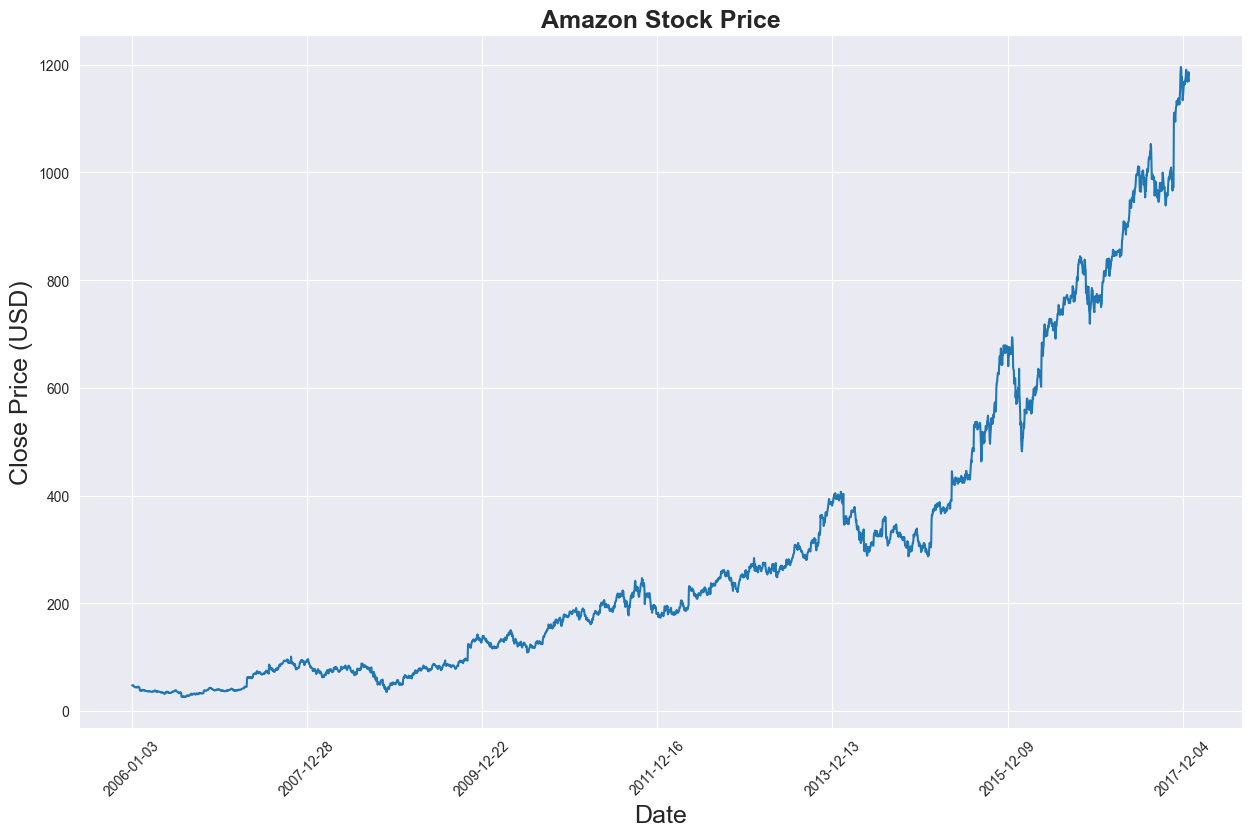

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(df[['Close']])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [47]:


# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [48]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [49]:
data = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

# Normalize data
scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(data)

scaler_y = MinMaxScaler()
scaled_x = scaler_y.fit_transform(target)

In [50]:
data_scaled = np.hstack((data_scaled, scaled_x))

In [51]:
data.head()

,Open,High,Low,Volume
0,47.47,47.85,46.25,7582127
1,47.48,47.73,46.69,7440914
2,47.16,48.20,47.11,5417258
3,47.97,48.58,47.32,6154285
4,46.55,47.10,46.40,8945056


### Prepare data

In [52]:
# Dataset class
class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len, :]
        # Target: The 'close' value at the next time step
        y = self.data[idx + self.seq_len, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
   

In [53]:
# Split data
seq_len = 20 # Lookback
train_size = int(len(data_scaled) * 0.8)
valid_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - valid_size

train_data = data_scaled[:train_size]
valid_data = data_scaled[train_size:train_size + valid_size]
test_data = data_scaled[train_size + valid_size:]

In [54]:
# Prepare for multivariate prediction
train_dataset = StockDataset(train_data, seq_len)
valid_dataset = StockDataset(valid_data, seq_len)
test_dataset = StockDataset(test_data, seq_len)

# Call set_seed to ensure reproducibility
set_seed(42)

# Create a generator for shuffling with the same seed
generator = torch.Generator().manual_seed(42)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [55]:
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [56]:
def train_and_evaluate(model, train_loader, valid_loader, device, epochs=100):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    rmse = 0

    set_seed(42)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(x_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        valid_loss = 0
        y_preds, y_trues = [], []
        with torch.no_grad():
            for x_batch, y_batch in valid_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = model(x_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                valid_loss += loss.item()
                y_preds.extend(y_pred.cpu().numpy())
                y_trues.extend(y_batch.cpu().numpy())

        # Inverse transform predictions and true values to original scale
        y_preds_original = scaler_y.inverse_transform(np.array(y_preds).reshape(-1, 1)).flatten()
        y_trues_original = scaler_y.inverse_transform(np.array(y_trues).reshape(-1, 1)).flatten()

        valid_loss /= len(valid_loader)
        rmse = np.sqrt(mean_squared_error(y_trues_original, y_preds_original))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, RMSE: {rmse}")

    return model, rmse

In [57]:
import matplotlib.pyplot as plt

def plot_predictions(model, data_loader, device, title="Predictions vs Actual"):
    model.eval()
    y_preds, y_trues = [], []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch).squeeze()
            y_preds.extend(y_pred.cpu().numpy())
            y_trues.extend(y_batch.cpu().numpy())

    # Inverse transform predictions and true values to original scale
    y_preds_original = scaler_y.inverse_transform(np.array(y_preds).reshape(-1, 1)).flatten()
    y_trues_original = scaler_y.inverse_transform(np.array(y_trues).reshape(-1, 1)).flatten()

    # Calculate final loss and RMSE
    final_mse_loss = np.mean((y_trues_original-y_preds_original)**2)
    final_rmse = np.sqrt(final_mse_loss)

    print(f"Final Loss: {final_mse_loss}, Final RMSE: {final_rmse}")

    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(y_trues_original, label="Actual", color="blue", linewidth=2)
    plt.plot(y_preds_original, label="Predicted", color="orange", linestyle="--", linewidth=2)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

### Multivariable prediction

In [58]:
# Main script
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 5 # Multivarible
hidden_dim = 64

In [59]:
print("Vanilla RNN:")
rnn_model_multi = VanillaRNN(input_dim, hidden_dim)
rnn_model_multi, rnn_model_multi_rmse = train_and_evaluate(rnn_model_multi, train_loader, valid_loader, device)

Vanilla RNN:
Epoch 1/100, Train Loss: 0.0024445189306118806, Valid Loss: 0.0020429300609976055, RMSE: 49.14137649536133
Epoch 2/100, Train Loss: 5.19877591949281e-05, Valid Loss: 0.001000266126357019, RMSE: 34.21971893310547
Epoch 3/100, Train Loss: 2.859805810753881e-05, Valid Loss: 0.0005339721741620451, RMSE: 24.807878494262695
Epoch 4/100, Train Loss: 2.5278314631960758e-05, Valid Loss: 0.0007677706016693264, RMSE: 29.973844528198242
Epoch 5/100, Train Loss: 2.4813821159784167e-05, Valid Loss: 0.0006091408606152982, RMSE: 26.727834701538086
Epoch 6/100, Train Loss: 2.4338603093622768e-05, Valid Loss: 0.000555566477123648, RMSE: 25.522945404052734
Epoch 7/100, Train Loss: 2.4710704900299835e-05, Valid Loss: 0.0004883492947556078, RMSE: 23.9133243560791
Epoch 8/100, Train Loss: 2.393821681547898e-05, Valid Loss: 0.0007060456555336714, RMSE: 28.947620391845703
Epoch 9/100, Train Loss: 2.353971434020327e-05, Valid Loss: 0.0006314879923593253, RMSE: 27.34526252746582
Epoch 10/100, Train

Final Loss: 143.73776245117188, Final RMSE: 11.989068031311035


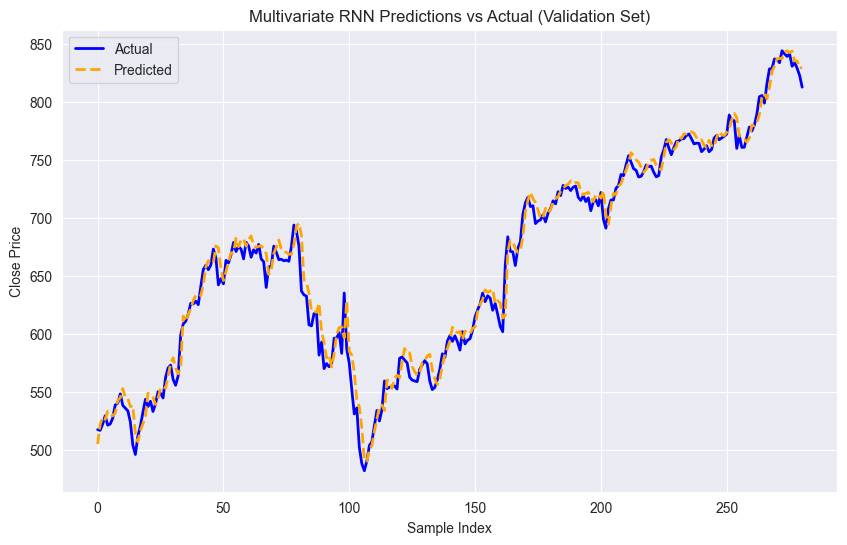

In [60]:
plot_predictions(rnn_model_multi, valid_loader, device, title="Multivariate RNN Predictions vs Actual (Validation Set)")

In [61]:
print("\nLSTM:")
lstm_model_multi = LSTM(input_dim=input_dim, hidden_dim=hidden_dim)
lstm_model_multi, lstm_model_multi_rmse = train_and_evaluate(lstm_model_multi, train_loader, valid_loader, device)


LSTM:
Epoch 1/100, Train Loss: 0.003921628688419189, Valid Loss: 0.0005630023340927437, RMSE: 27.376544952392578
Epoch 2/100, Train Loss: 0.000121862671413079, Valid Loss: 0.00033438049722462894, RMSE: 21.190616607666016
Epoch 3/100, Train Loss: 5.2404200352229004e-05, Valid Loss: 0.00027632726996671406, RMSE: 19.46567153930664
Epoch 4/100, Train Loss: 4.507537687459262e-05, Valid Loss: 0.00032981651020236313, RMSE: 20.668222427368164
Epoch 5/100, Train Loss: 4.5573011017327904e-05, Valid Loss: 0.00042750678840093316, RMSE: 23.151992797851562
Epoch 6/100, Train Loss: 4.501832944170976e-05, Valid Loss: 0.0002832381098414771, RMSE: 19.50000762939453
Epoch 7/100, Train Loss: 4.181468966635293e-05, Valid Loss: 0.00035264877369627355, RMSE: 21.23573112487793
Epoch 8/100, Train Loss: 3.988455223167732e-05, Valid Loss: 0.000336545062600635, RMSE: 20.727802276611328
Epoch 9/100, Train Loss: 5.27730184522194e-05, Valid Loss: 0.00038171529886312785, RMSE: 21.98784065246582
Epoch 10/100, Train L

Final Loss: 147.17694091796875, Final RMSE: 12.1316499710083


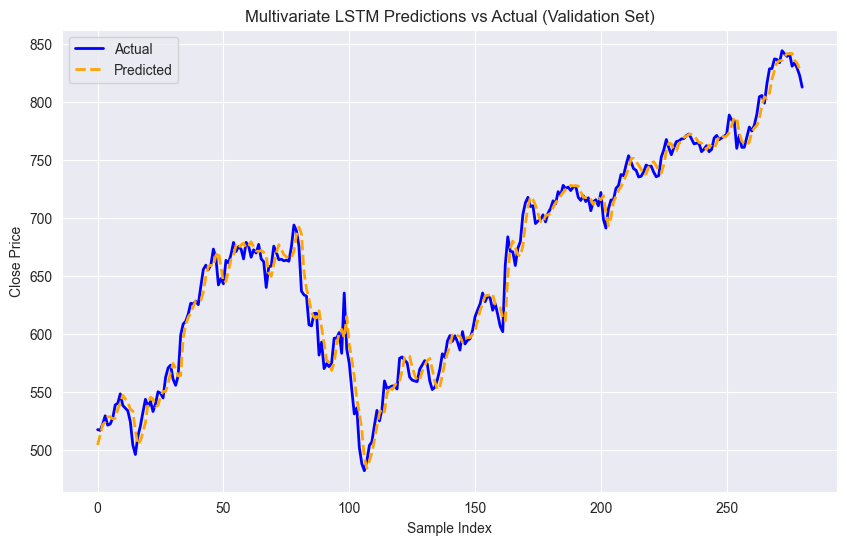

In [62]:
plot_predictions(lstm_model_multi, valid_loader, device, title="Multivariate LSTM Predictions vs Actual (Validation Set)")

In [63]:
print("\nGRU:")
gru_model_multi = GRU(input_dim=input_dim, hidden_dim=hidden_dim)
gru_model_multi, gru_model_multi_rmse = train_and_evaluate(gru_model_multi, train_loader, valid_loader, device)


GRU:
Epoch 1/100, Train Loss: 0.007159573874607878, Valid Loss: 0.006956454692408442, RMSE: 92.27569580078125
Epoch 2/100, Train Loss: 0.00016536734725186282, Valid Loss: 0.00025307466567028316, RMSE: 18.072145462036133
Epoch 3/100, Train Loss: 3.8986699492900366e-05, Valid Loss: 0.0002564095688285306, RMSE: 18.23546600341797
Epoch 4/100, Train Loss: 3.3301020218794675e-05, Valid Loss: 0.00026569805922918024, RMSE: 18.524276733398438
Epoch 5/100, Train Loss: 3.190510261973893e-05, Valid Loss: 0.0002487843477865681, RMSE: 18.020469665527344
Epoch 6/100, Train Loss: 2.864170145537508e-05, Valid Loss: 0.00021814452775288374, RMSE: 16.98409652709961
Epoch 7/100, Train Loss: 2.682284172662644e-05, Valid Loss: 0.0002151486143702641, RMSE: 16.8843936920166
Epoch 8/100, Train Loss: 2.5580135666371606e-05, Valid Loss: 0.00020167586772004142, RMSE: 16.36410140991211
Epoch 9/100, Train Loss: 2.5294113464425256e-05, Valid Loss: 0.00021995315910317004, RMSE: 16.983491897583008
Epoch 10/100, Train 

Final Loss: 141.173828125, Final RMSE: 11.881659507751465


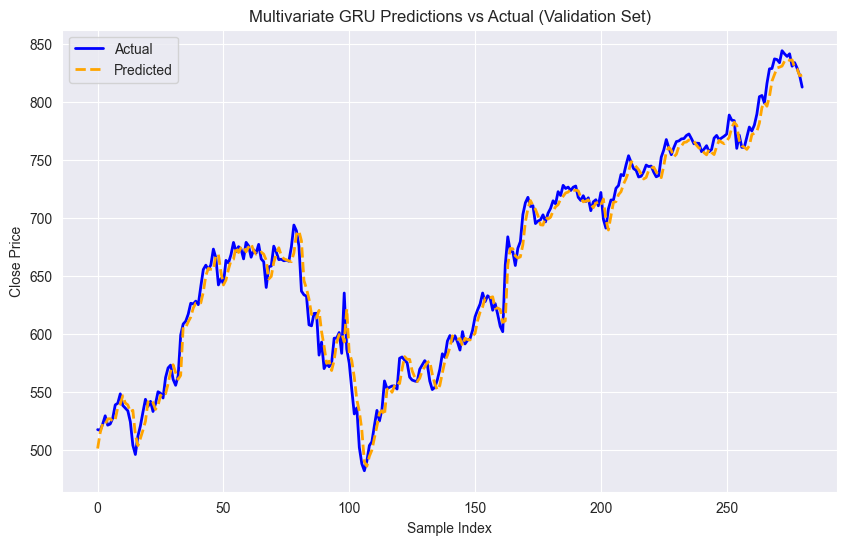

In [64]:
# Plot predictions for the validation set
plot_predictions(gru_model_multi, valid_loader, device, title="Multivariate GRU Predictions vs Actual (Validation Set)")

### Single

In [65]:
class StockDatasetSingle(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        # Input: Sequence of `close` values
        x = self.data[idx:idx + self.seq_len, -1].reshape(-1, 1)  # Only the 'close' column
        # Target: The next `close` value
        y = self.data[idx + self.seq_len, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [66]:
train_dataset_single = StockDatasetSingle(train_data, seq_len)
valid_dataset_single = StockDatasetSingle(valid_data, seq_len)
test_dataset_single = StockDatasetSingle(test_data, seq_len)

train_loader_single = DataLoader(train_dataset_single, batch_size=64, shuffle=True, generator=generator)
valid_loader_single = DataLoader(valid_dataset_single, batch_size=64, shuffle=False)
test_loader_single = DataLoader(test_dataset_single, batch_size=64, shuffle=False)

In [67]:
# Main script
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 50

In [68]:
print("Vanilla RNN:")
rnn_model = VanillaRNN(input_dim, hidden_dim)
rnn_model, rnn_rmse = train_and_evaluate(rnn_model, train_loader_single, valid_loader_single, device)

Vanilla RNN:
Epoch 1/100, Train Loss: 0.02153134235720101, Valid Loss: 0.1540553241968155, RMSE: 442.34033203125
Epoch 2/100, Train Loss: 0.005200848975954087, Valid Loss: 0.03420056216418743, RMSE: 206.6280059814453
Epoch 3/100, Train Loss: 0.0003064588970932834, Valid Loss: 0.00121756891021505, RMSE: 36.201725006103516
Epoch 4/100, Train Loss: 3.8660096690460034e-05, Valid Loss: 0.0024109454243443906, RMSE: 52.34870529174805
Epoch 5/100, Train Loss: 3.7740163191445296e-05, Valid Loss: 0.0023908574250526725, RMSE: 52.274330139160156
Epoch 6/100, Train Loss: 3.2593333799013635e-05, Valid Loss: 0.002120682306122035, RMSE: 49.08975601196289
Epoch 7/100, Train Loss: 3.59219732337423e-05, Valid Loss: 0.00159197204047814, RMSE: 42.109493255615234
Epoch 8/100, Train Loss: 3.281352076699381e-05, Valid Loss: 0.0015877296333201229, RMSE: 42.093833923339844
Epoch 9/100, Train Loss: 3.290191577769675e-05, Valid Loss: 0.0019794922322034837, RMSE: 47.535709381103516
Epoch 10/100, Train Loss: 3.3639

Final Loss: 267.5986633300781, Final RMSE: 16.358442306518555


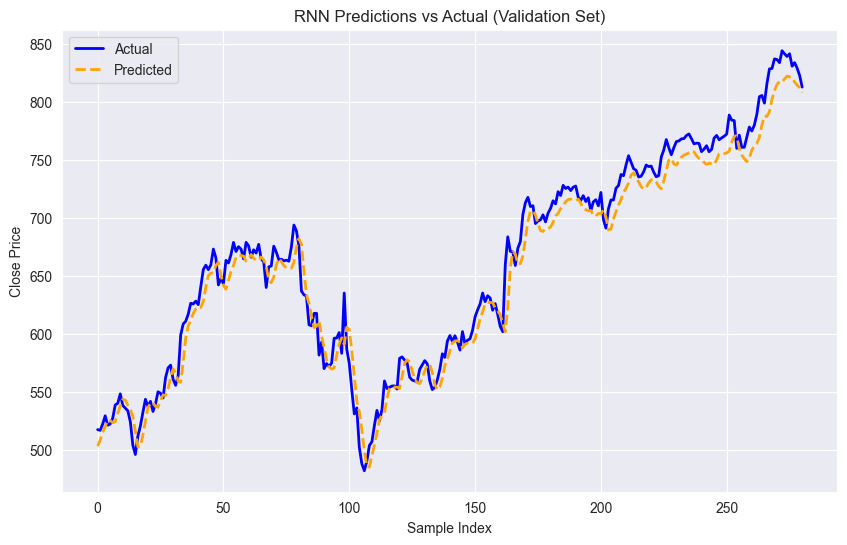

In [69]:
plot_predictions(rnn_model, valid_loader_single, device, title="RNN Predictions vs Actual (Validation Set)")

In [70]:
print("\nLSTM:")
lstm_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim)
lstm_model, lstm_rmse = train_and_evaluate(lstm_model, train_loader_single, valid_loader_single, device)


LSTM:
Epoch 1/100, Train Loss: 0.007629142694273277, Valid Loss: 0.04631556905806065, RMSE: 242.80215454101562
Epoch 2/100, Train Loss: 0.0004885485813199347, Valid Loss: 0.0026924787554889916, RMSE: 58.53261184692383
Epoch 3/100, Train Loss: 8.505871186284104e-05, Valid Loss: 0.0006179546966450289, RMSE: 29.912582397460938
Epoch 4/100, Train Loss: 5.7489512360725235e-05, Valid Loss: 0.00039940258429851385, RMSE: 23.84806251525879
Epoch 5/100, Train Loss: 6.06851126097976e-05, Valid Loss: 0.0004146257386310026, RMSE: 24.516223907470703
Epoch 6/100, Train Loss: 5.838928791490616e-05, Valid Loss: 0.000444493952090852, RMSE: 24.38266944885254
Epoch 7/100, Train Loss: 5.9821622447711174e-05, Valid Loss: 0.0005252340110018849, RMSE: 26.07440948486328
Epoch 8/100, Train Loss: 5.617942277144481e-05, Valid Loss: 0.0003932550811441615, RMSE: 23.24575424194336
Epoch 9/100, Train Loss: 6.815852860822098e-05, Valid Loss: 0.0004411818605149165, RMSE: 24.33405303955078
Epoch 10/100, Train Loss: 5.4

Final Loss: 230.1588134765625, Final RMSE: 15.17098617553711


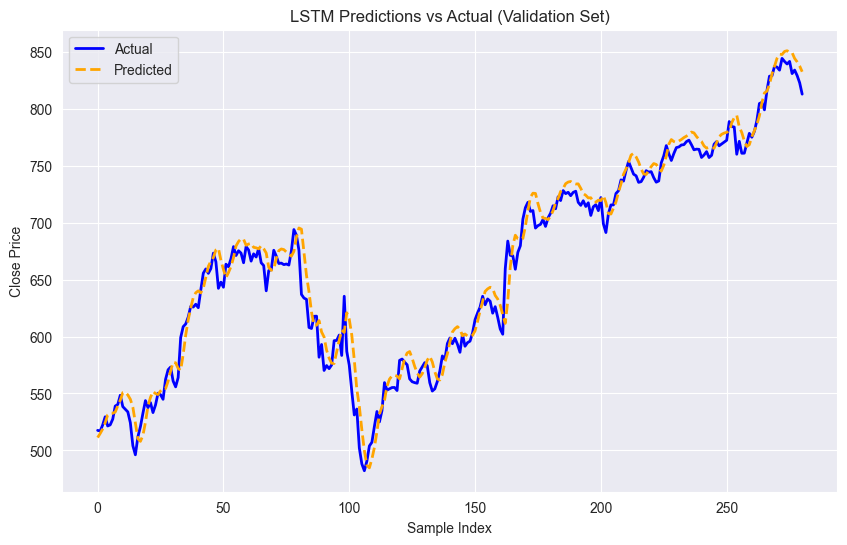

In [71]:
plot_predictions(lstm_model, valid_loader_single, device, title="LSTM Predictions vs Actual (Validation Set)")

In [72]:
print("\nGRU:")
gru_model = GRU(input_dim=input_dim, hidden_dim=hidden_dim)
gru_model, gru_rmse = train_and_evaluate(gru_model, train_loader_single, valid_loader_single, device)


GRU:
Epoch 1/100, Train Loss: 0.018259107833728194, Valid Loss: 0.16404574513435363, RMSE: 456.0904235839844
Epoch 2/100, Train Loss: 0.006727083194020547, Valid Loss: 0.09663352817296982, RMSE: 349.24755859375
Epoch 3/100, Train Loss: 0.003301279591764078, Valid Loss: 0.015031191892921925, RMSE: 137.4210205078125
Epoch 4/100, Train Loss: 0.00018207729331870244, Valid Loss: 0.0002839153807144612, RMSE: 19.674968719482422
Epoch 5/100, Train Loss: 4.175664099947378e-05, Valid Loss: 0.00031488236854784193, RMSE: 21.40842056274414
Epoch 6/100, Train Loss: 3.794081744433099e-05, Valid Loss: 0.0002536812564358115, RMSE: 19.249053955078125
Epoch 7/100, Train Loss: 3.574378584552936e-05, Valid Loss: 0.0002511202619643882, RMSE: 19.18183135986328
Epoch 8/100, Train Loss: 3.354307227709796e-05, Valid Loss: 0.00022748421470168977, RMSE: 18.227720260620117
Epoch 9/100, Train Loss: 3.204468808498381e-05, Valid Loss: 0.00020705670467577875, RMSE: 17.226303100585938
Epoch 10/100, Train Loss: 3.28660

Final Loss: 185.9367218017578, Final RMSE: 13.63586139678955


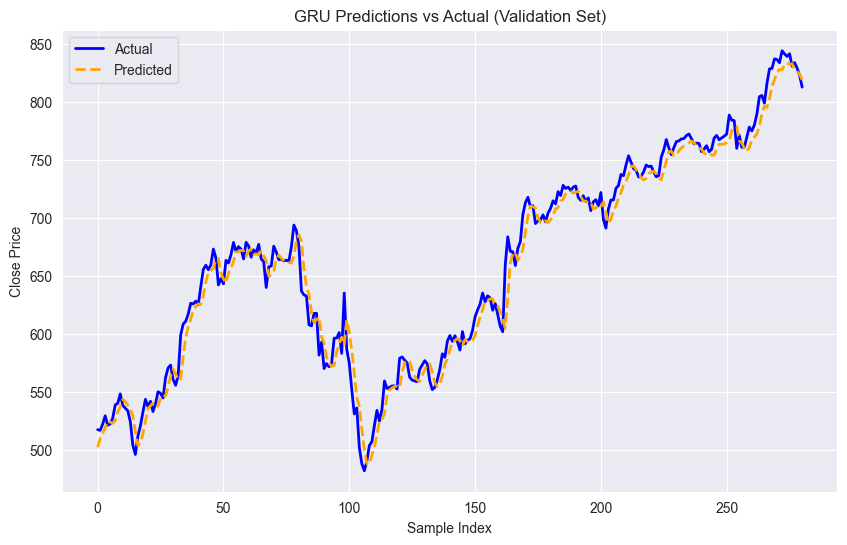

In [73]:
# Plot predictions for the validation set
plot_predictions(gru_model, valid_loader_single, device, title="GRU Predictions vs Actual (Validation Set)")

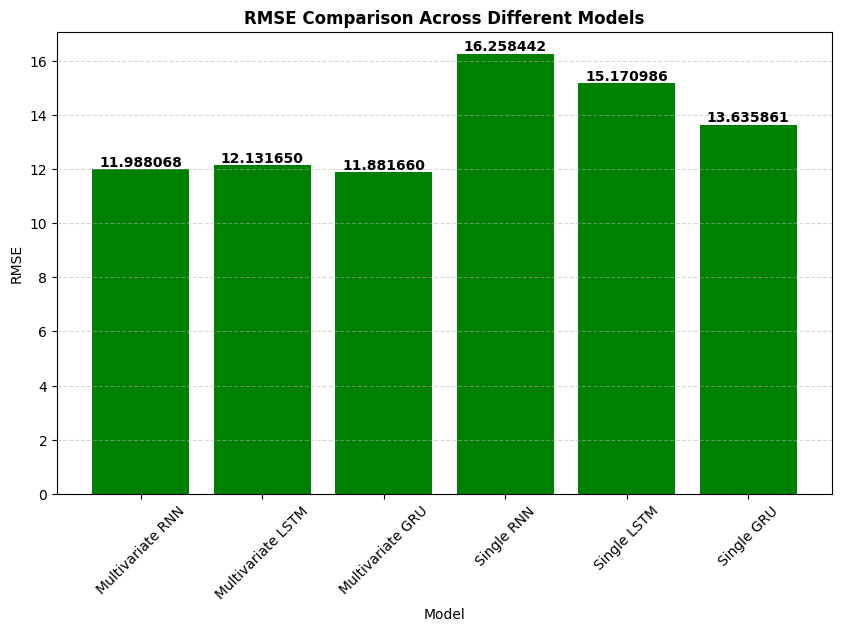

In [ ]:
import matplotlib.pyplot as plt

model_names = ["Multivariate RNN", "Multivariate LSTM", "Multivariate GRU", "Single RNN", "Single LSTM", "Single GRU"]
rmse_values = [rnn_model_multi_rmse, lstm_model_multi_rmse, gru_model_multi_rmse, rnn_rmse, lstm_rmse, gru_rmse] 

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse_values, color='green')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Comparison Across Different Models", fontweight = 'bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Display the RMSE values on top of each bar
for i, value in enumerate(rmse_values):
    plt.text(i, value , f"{value:.6f}", ha="center", va="bottom", fontweight = 'bold')

plt.show()


### Hyperparameters for GRU

In [75]:
import torch
from torch.utils.data import DataLoader
import numpy as np


# Example ranges for grid search
lookback_values = [10, 20, 30]
hidden_dim_values = [32, 64, 128]

# Function to train and evaluate the model
def train_and_evaluate_model(lookback, hidden_dim, train_data, valid_data, seq_len):
    # Prepare datasets with the current lookback (seq_len)
    train_dataset = StockDataset(train_data, seq_len=seq_len)
    valid_dataset = StockDataset(valid_data, seq_len=seq_len)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

    # Initialize GRU model with the current hidden_dim
    model = GRU(input_dim=train_data.shape[1], hidden_dim=hidden_dim, output_dim=1).to(device)

    # Train and evaluate the model (adapt your train function to return validation RMSE)
    model, valid_rmse = train_and_evaluate(model, train_loader, valid_loader, device)

    return model, valid_rmse

# Dictionary to store RMSE results for each configuration
results = {}
best_model = None
best_rmse = float('inf')
best_config = None

# Grid search over lookback and hidden_dim
for lookback in lookback_values:
    for hidden_dim in hidden_dim_values:
        set_seed(42)
        print(f"Training model with lookback={lookback}, hidden_dim={hidden_dim}")

        # Train and evaluate the model for the current configuration
        model, valid_rmse = train_and_evaluate_model(lookback, hidden_dim, train_data, valid_data, seq_len=lookback)

        # Store the result
        results[(lookback, hidden_dim)] = valid_rmse
        print(f"Validation RMSE for lookback={lookback}, hidden_dim={hidden_dim}: {valid_rmse}")

        # Check if this model has the best RMSE so far
        if valid_rmse < best_rmse:
            best_rmse = valid_rmse
            best_model = model
            best_config = (lookback, hidden_dim)

# After the grid search, the best model is stored in `best_model`
print(f"Best configuration: Lookback={best_config[0]}, Hidden Dim={best_config[1]} with RMSE={best_rmse}")

Training model with lookback=10, hidden_dim=32
Epoch 1/100, Train Loss: 0.00395805243552834, Valid Loss: 0.005017520952969789, RMSE: 79.7110595703125
Epoch 2/100, Train Loss: 9.573338645982164e-05, Valid Loss: 0.0010287197888828813, RMSE: 35.89348602294922
Epoch 3/100, Train Loss: 3.681510243998338e-05, Valid Loss: 0.00048411361640319226, RMSE: 24.635906219482422
Epoch 4/100, Train Loss: 3.110253445763527e-05, Valid Loss: 0.0004810546466615051, RMSE: 24.58842658996582
Epoch 5/100, Train Loss: 2.892603238012127e-05, Valid Loss: 0.000521155446767807, RMSE: 25.635452270507812
Epoch 6/100, Train Loss: 2.6620335024505804e-05, Valid Loss: 0.00042997958371415734, RMSE: 23.325748443603516
Epoch 7/100, Train Loss: 2.7731802674679784e-05, Valid Loss: 0.0004959248646628112, RMSE: 25.040809631347656
Epoch 8/100, Train Loss: 2.5646464349081628e-05, Valid Loss: 0.000391300959745422, RMSE: 22.298799514770508
Epoch 9/100, Train Loss: 2.5474365884292638e-05, Valid Loss: 0.00033170332899317144, RMSE: 20

In [76]:
print(results)

{(10, 32): 11.918355, (10, 64): 14.714367, (10, 128): 12.518208, (20, 32): 13.718371, (20, 64): 17.999659, (20, 128): 11.494836, (30, 32): 11.71408, (30, 64): 17.522131, (30, 128): 11.445438}


In [77]:
# Find the best configuration based on validation RMSE
best_params = min(results, key=results.get)
best_rmse = results[best_params]
print(f"Best configuration: Lookback={best_params[0]}, Hidden Dim={best_params[1]} with RMSE={best_rmse}")

Best configuration: Lookback=30, Hidden Dim=128 with RMSE=11.445438385009766


### Test the best model

Final Loss: 175.1114959716797, Final RMSE: 13.232970237731934


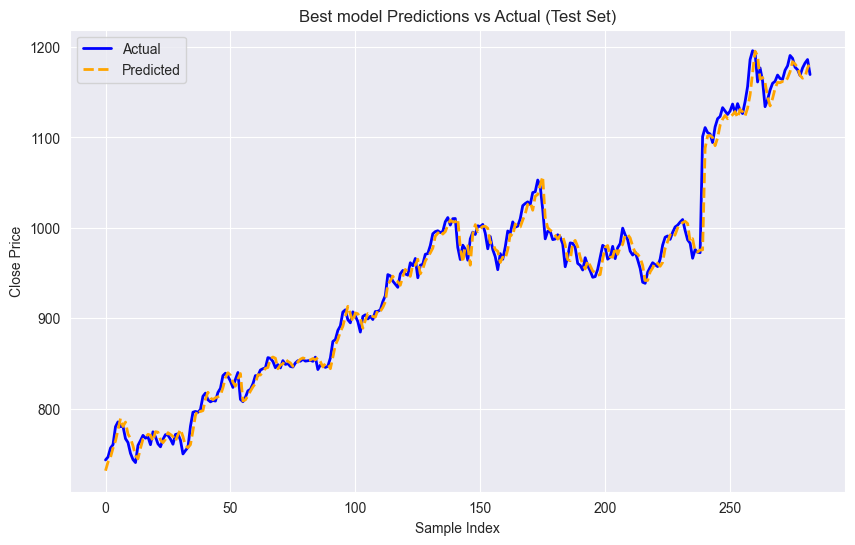

In [78]:
plot_predictions(best_model, test_loader, device, title="Best model Predictions vs Actual (Test Set)")